In [283]:
import spotipy
import spotipy.oauth2 as oauth2
import pandas as pd
from sklearn.cluster import KMeans



import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from pathlib import Path

In [292]:
credentials = oauth2.SpotifyClientCredentials(
    client_id=Path('/Users/juliacreighton/Desktop/key.txt').read_text(), 
    client_secret=Path('/Users/juliacreighton/Desktop/secret.txt').read_text())

token = credentials.get_access_token()
sp = spotipy.Spotify(auth=token)


In [190]:
# Data from https://benjaminbenben.com/lastfm-to-csv/

listening = pd.read_csv('/Users/juliacreighton/Downloads/juliacreighton (1).csv',header=None)


In [191]:
listening.columns = ['Artist_Name','Album','Song','Date']
artists = listening[['Artist_Name']].drop_duplicates()

In [192]:
artists.head()
artists['ID'] = ''
artists['Spotify_ID']= ''
artists['SpotifyGenre']= ''
artist_names = artists.values.tolist()

In [193]:
for i in (artist_names):
        artist_name = i[0]
        
        result = sp.search(artist_name,limit=1,type='artist')
        
        if not (result['artists']['items']):
            i[2] = ''
            i[3] = ''

        else:
            art_id = result['artists']['items'][0]['id']
            art_genres = result['artists']['items'][0]['genres']
            i[2] = art_id
            i[3] = art_genres
    
final = []
for row in artist_names:
        for genre in row[3]:
            final.append([row[0],row[1],row[2], genre,])

artists = pd.DataFrame(final,columns=['Artist_Name','ID','Spotify_ID','Genre'])
artists= artists.iloc[1:] 
artists = artists.drop_duplicates()

In [194]:
artists.head()

,Artist_Name,ID,Spotify_ID,Spotify_Genre
0,Beach House,,,
1,Childish Gambino,,73sIBHcqh3Z3NyqHKZ7FOL,hip hop
2,Childish Gambino,,73sIBHcqh3Z3NyqHKZ7FOL,pop rap
3,Childish Gambino,,73sIBHcqh3Z3NyqHKZ7FOL,rap
4,Litany,,2z6JjrrJKNLilqlx8mlxcc,vapor soul


In [195]:
artists = artists[artists.Spotify_ID!='Unknown']

In [196]:
artist_dummies = pd.get_dummies(artists, columns=['Spotify_Genre'])

In [197]:
artist_dummies.drop(['ID'],inplace=True,axis=1)

In [198]:
artist_dummies = artist_dummies.groupby(by=['Artist_Name','Spotify_ID']).sum()

In [199]:
# hierarchical clustering 

In [200]:
ward = AgglomerativeClustering(n_clusters=10, linkage='ward').fit(artist_dummies)
label = ward.labels_
artist_dummies['ward_hier'] =ward.labels_

In [237]:

my_listening_labelled = artists.merge(artist_dummies[['Artist_Name','ward_hier']],on ='Artist_Name')

my_listening_labelled = my_listening_labelled.groupby(['ward_hier','Spotify_Genre'],as_index=False).count()
my_listening_labelled.sort_values(by=['ward_hier','Spotify_ID'],ascending=False,inplace=True)
my_listening_labelled =  my_listening_labelled.merge(my_listening_labelled[['ward_hier','Spotify_Genre','Artist_Name']],on = 'ward_hier')


my_listening_labelled = my_listening_labelled[my_listening_labelled['Spotify_Genre_x']!= my_listening_labelled['Spotify_Genre_y']]
my_listening_labelled['Genre'] = my_listening_labelled['Spotify_Genre_x'] + '/' + my_listening_labelled['Spotify_Genre_y']
my_listening_labelled['Artist_Name_Total'] = my_listening_labelled['Artist_Name_x'] + my_listening_labelled['Artist_Name_y']
my_listening_labelled= my_listening_labelled[['ward_hier','Genre','Artist_Name_Total']]
my_listening_labelled.sort_values(by=['ward_hier','Artist_Name_Total'],ascending=False,inplace=True)
my_listening_labelled = my_listening_labelled[my_listening_labelled.index % 2 != 0]
my_listening_labelled['Rank'] = my_listening_labelled.sort_values(['ward_hier','Artist_Name_Total'], ascending=[True,False]).groupby(['ward_hier']).cumcount() + 1
my_listening_labelled = my_listening_labelled[my_listening_labelled.Rank==1]





In [238]:
my_listening_labelled

,ward_hier,Genre,Artist_Name_Total,Rank
1,9,rap/pop rap,107,1
1119,8,soul/funk,22,1
2039,7,classic rock/rock,77,1
4491,6,dance pop/post-teen pop,62,1
6011,5,chamber pop/indie folk,36,1
9261,4,hip hop/gangster rap,51,1
10629,3,modern rock/indie pop,59,1
13439,2,pop/tropical house,57,1
53039,1,pop rock/post-grunge,73,1
58969,0,indietronica/indie pop,87,1


In [246]:
labeled = artist_dummies[['Artist_Name','Spotify_ID','ward_hier']].merge(listening, on = 'Artist_Name')

In [247]:
labeled = labeled.merge(my_listening_labelled[['ward_hier','Genre']], on =['ward_hier'])

In [248]:
labeled['Date'] = pd.to_datetime(labeled['Date'])

In [264]:
labeled

,Artist_Name,Spotify_ID,ward_hier,Album,Song,Date,Genre,Day
0,2 Chainz,17lzZA2AlOHwCwFALHttmp,9,Pretty Girls Like Trap Music,4 AM,2018-03-06 04:43:00,rap/pop rap,2018-03-06
1,2 Chainz,17lzZA2AlOHwCwFALHttmp,9,Hibachi for Lunch,Good Drank,2017-08-08 05:14:00,rap/pop rap,2017-08-08
2,2 Chainz,17lzZA2AlOHwCwFALHttmp,9,Hibachi for Lunch,Good Drank,2017-05-20 16:44:00,rap/pop rap,2017-05-20
3,A Boogie Wit da Hoodie,31W5EY0aAly4Qieq6OFu6I,9,Drowning (feat. Kodak Black),Drowning (feat. Kodak Black),2017-08-08 03:43:00,rap/pop rap,2017-08-08
4,A$AP Ferg,5dHt1vcEm9qb8fCyLcB3HL,9,Still Striving,Plain Jane,2017-11-09 03:06:00,rap/pop rap,2017-11-09
5,A$AP Ferg,5dHt1vcEm9qb8fCyLcB3HL,9,New Level,New Level,2016-10-14 15:57:00,rap/pop rap,2016-10-14
6,A$AP Ferg,5dHt1vcEm9qb8fCyLcB3HL,9,New Level,New Level,2016-10-14 01:19:00,rap/pop rap,2016-10-14
7,A$AP Ferg,5dHt1vcEm9qb8fCyLcB3HL,9,Trap Lord,Work Remix,2016-10-03 21:57:00,rap/pop rap,2016-10-03
8,A$AP Ferg,5dHt1vcEm9qb8fCyLcB3HL,9,Trap Lord,SHABBA,2016-09-08 00:45:00,rap/pop rap,2016-09-08
9,A$AP Ferg,5dHt1vcEm9qb8fCyLcB3HL,9,Trap Lord,SHABBA,2016-06-21 21:32:00,rap/pop rap,2016-06-21


In [253]:
groups = artists[['Artist_Name','Spotify_ID','Spotify_Genre']].merge(artist_dummies[['ward_hier','Artist_Name','Spotify_ID']].reset_index(), on = ['Artist_Name','Spotify_ID'])

In [254]:
counts = groups[['Artist_Name','ward_hier','Spotify_Genre']].groupby(['ward_hier','Spotify_Genre'],as_index=False).count()

In [255]:
labeled['Day'] = labeled['Date'].dt.date

In [257]:
counts['Rank']= counts['Artist_Name'].rank(ascending=False)

In [265]:
grouped_labeled = labeled[['Day','Genre','Song']].groupby(['Day','Genre'],as_index=False).count()

In [266]:
pivoted = grouped_labeled.pivot(index='Day',columns='Genre',values='Song')

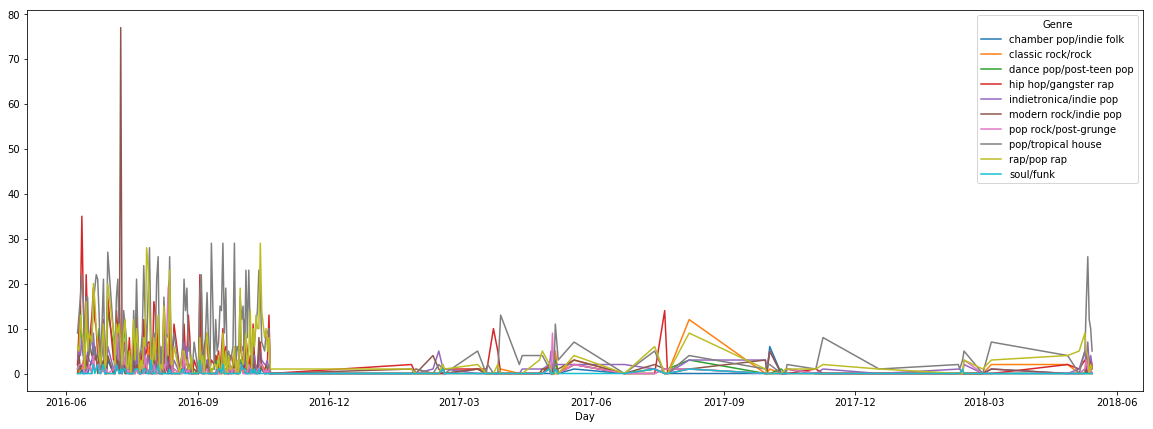

In [268]:
pivoted.fillna(0).plot(figsize=(20,7),kind='line')

In [279]:
pivoted.reset_index()['Day'] >= pd.to_datetime('2018-05-01')

TypeError: Cannot compare type 'Timestamp' with type 'date'

In [282]:
labeled[['Genre','Artist_Name']].drop_duplicates().to_csv('~/Desktop/Genres.csv',index=None)